# MLPをスクラッチ実装

MLP

- 隠れ層のニューロンの数：　30
- 隠れ層の活性化関数にはReLUを使用
- モデルの関数を作成し、順伝播で予測した結果を返す

ヒント

- mnistのデータをtrain/test分割し、trainのデータに対して順伝播し予測値を出す
- パラメータは、隠れ層が1つしかないので、W1,b1,W2,b2がパラメータ。これらを初期化する
- これらを線型結合する関数linear(X,W,b)を作成（XW.T+b）
- ReLUの関数も作る
- これらを組み合わせたmodelを作る
- 最終層にはsoftmaxを使用

## データロード/前処理

In [1]:
import torch
from sklearn.model_selection import train_test_split
from sklearn import datasets
from torch.nn import functional as F

In [2]:
# データロード
dataset = datasets.load_digits()
images = dataset['images']
target = dataset['target']

# 学習/検証データ分割
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(images, target, test_size=0.2, random_state=42)

# 前処理
from torch.nn import functional as F

# 2-1 モデルのone-hot　encoding
# ｔａｒｇｅｔのonehotでラベル化
y_train = F.one_hot(torch.tensor(y_train), num_classes=10)
y_val = F.one_hot(torch.tensor(y_val), num_classes=10)
# imagesのtensor化
X_train = torch.tensor(X_train, dtype=torch.float32).reshape(-1, 64)
X_val = torch.tensor(X_val, dtype=torch.float32).reshape(-1, 64)

# 2-2 画像の標準化
X_train_mean = X_train.mean()
X_train_std = X_train.std()
X_train = (X_train - X_train_mean) / X_train_std
X_val = (X_val - X_train_mean) / X_train_std

In [3]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

torch.Size([1437, 64])
torch.Size([360, 64])
torch.Size([1437, 10])
torch.Size([360, 10])


## 各データの形状確認

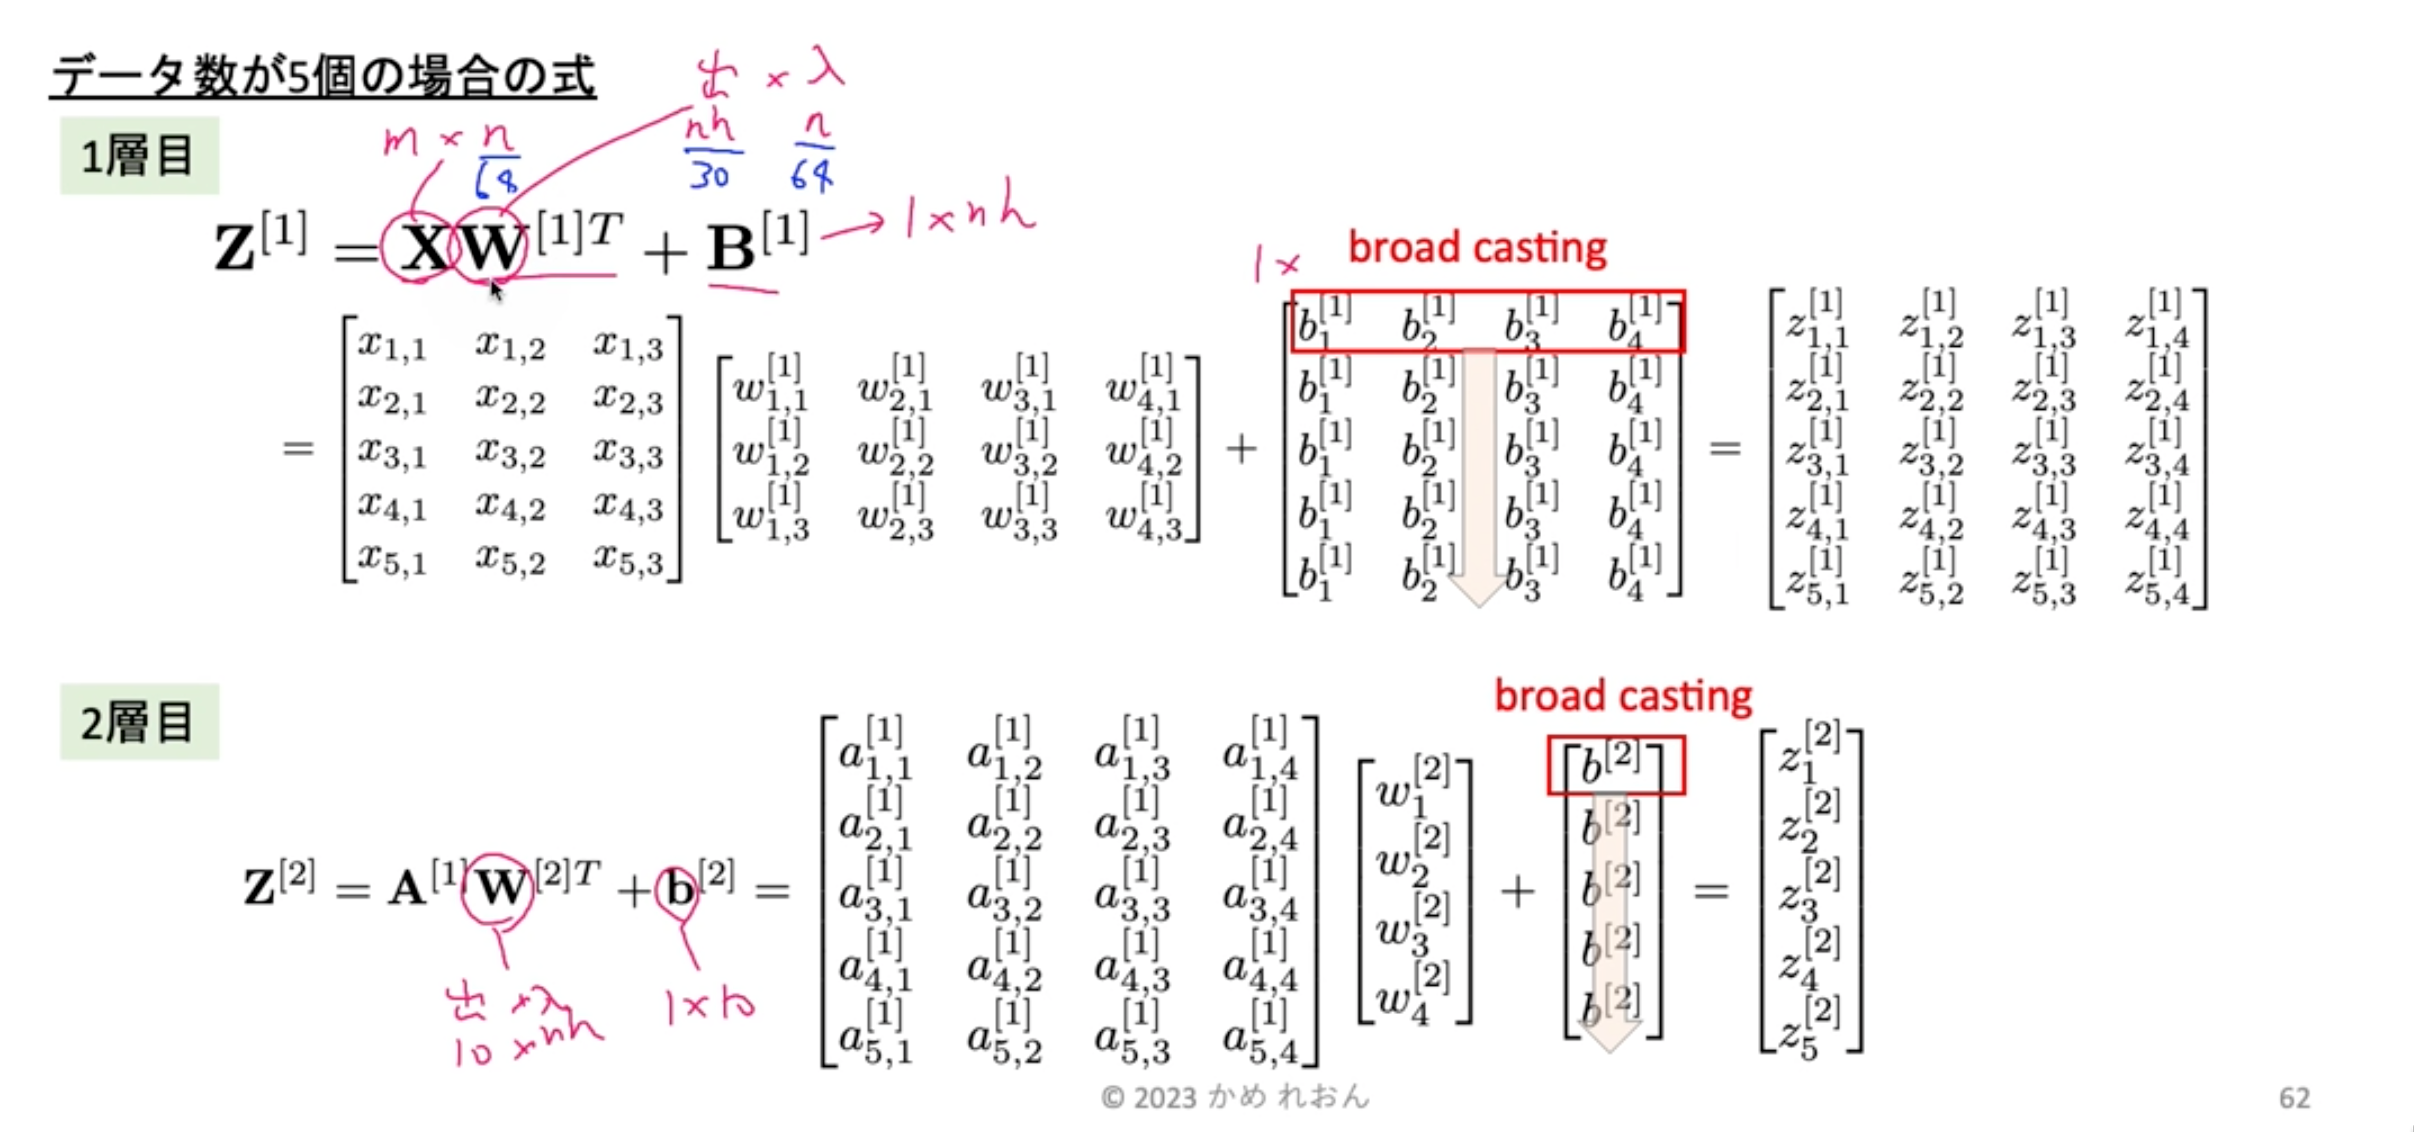

1層目(Z=XW.T+B) 
- X: データの数m　x 特徴量数n
- W: 出力nh x 入力n
    - 出力は隠れ層のニューロンの数(nh:number of hidden layer)
    - 入力は特徴量数と等しい
    - これが転置される
- B: 1 x nh

2層目(Z=AW.T+B)

- W: 出力10 x 入力nh
    - 出力はmnistの10クラス問題なので10
    - 1層目の層の出力がそのまま入力になるのでnh
- B: 1 x 10

今回隠れ層nh=30、mnistは8x8の64ピクセルなのでn=64


In [27]:
# パラメータ初期化
m, n = X_train.shape  # m:データ数、n特徴量数
nh = 30  # nh:隠れ層の数
class_num = 10  # 

## 1層目のW1,b1
W1 = torch.randn((nh, n), requires_grad=True)  # 出力nh x 入力n
ｂ1 = torch.zeros((1, nh), requires_grad=True)  # 1 X nh, biasは最初の初期値を0にすることがあるので0ベクトルにしておく

## 2層目のW2,b2
W2 = torch.randn((class_num, nh), requires_grad=True)  # 出力10 x 入力nh(1層目の出力)
ｂ2 = torch.zeros((1, class_num), requires_grad=True)  # 1 X nh

## 関数作成

In [28]:
# 線形変換(Z=XW.T+b)の関数
def linear(X, W, b):
    return X@W.T + b

In [29]:
Z1 = linear(X_train, W1, b1)

In [30]:
# データの数x隠れ層の数30
Z1.shape

torch.Size([1437, 30])

In [31]:
Z1[0]

tensor([ -5.2906,  -2.7117, -10.6180,  10.2270,   7.0021,   0.8018,   9.9884,
        -10.8497, -17.2561,   3.1806,  14.7517,  -6.6711,  -4.2914,   1.5464,
         -0.3399,  -4.8946,  -0.8385,   2.1792,   1.3512,   6.9088,   2.4772,
         -4.0681,  -7.4424,  -1.9692,  18.2838,  -0.4124,   3.1632,   5.8159,
         -7.2354,   2.0042], grad_fn=<SelectBackward0>)

In [32]:
# ReLU関数
def relu(Z):
    return Z.clamp_min(0.)

In [42]:
## .clamp_min(0.)の動きの確認
a = torch.tensor([-1., 0, -5, 2, 3, -2])
print(a)
print(a.clamp_min(0.))
print(a)  # aは上書きされない

tensor([-1.,  0., -5.,  2.,  3., -2.])
tensor([0., 0., 0., 2., 3., 0.])
tensor([-1.,  0., -5.,  2.,  3., -2.])


In [44]:
## .clamp_min_(0.) で関数の後にアンダースコアをつけると上書きされる
print(a)
print(a.clamp_min_(0.))
print(a)

tensor([0., 0., 0., 2., 3., 0.])
tensor([0., 0., 0., 2., 3., 0.])
tensor([0., 0., 0., 2., 3., 0.])


In [46]:
# 出力層で使うsoftmax関数
def softmax(x):
    e_x = torch.exp(x - torch.max(x, dim=-1, keepdim=True)[0])  # 分子
    sum_e_x = torch.sum(e_x, dim=-1, keepdim=True) + 1e-10  # 分母
    return e_x / sum_e_x

In [47]:
def model(X):
    Z1 = linear(X, W1, b1)
    A1 = relu(Z1)
    Z2 = linear(A1, W2, b2)
    A2 = softmax(Z2)
    return A2

In [48]:
y_train_pred = model(X_train)

In [50]:
y_train_pred.shape

torch.Size([1437, 10])

In [52]:
y_train_pred[0]

tensor([4.0015e-05, 7.7162e-03, 1.0092e-17, 9.9211e-01, 3.6758e-36, 3.3056e-21,
        1.3290e-04, 3.7287e-09, 4.2759e-15, 1.1732e-13],
       grad_fn=<SelectBackward0>)

In [59]:
y_train_pred.sum(dim=-1)

tensor([1., 1., 1.,  ..., 1., 1., 1.], grad_fn=<SumBackward1>)